Iter 0, Loss: 0.954333484172821
Iter 10, Loss: 0.8236551880836487
Iter 20, Loss: 0.7880721092224121
Iter 30, Loss: 0.747783899307251
Iter 40, Loss: 0.7112724781036377
Iter 50, Loss: 0.6751440167427063
Iter 60, Loss: 0.638140082359314
Iter 70, Loss: 0.6005511283874512
Iter 80, Loss: 0.5626651644706726
Iter 90, Loss: 0.5247344970703125


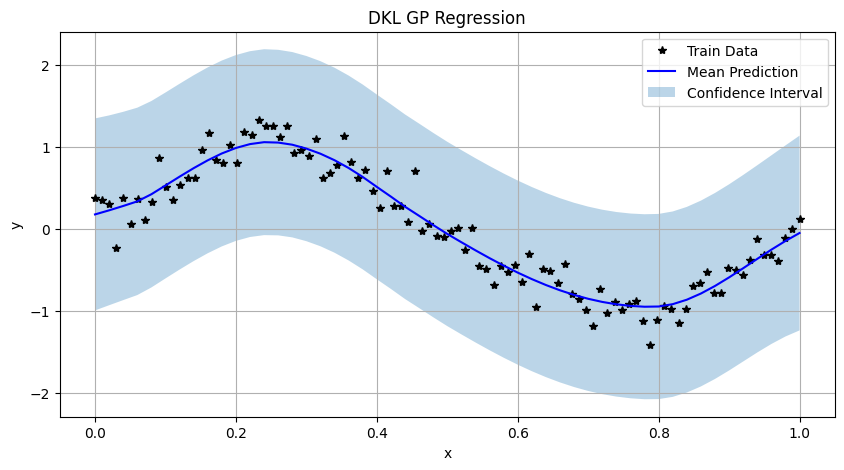

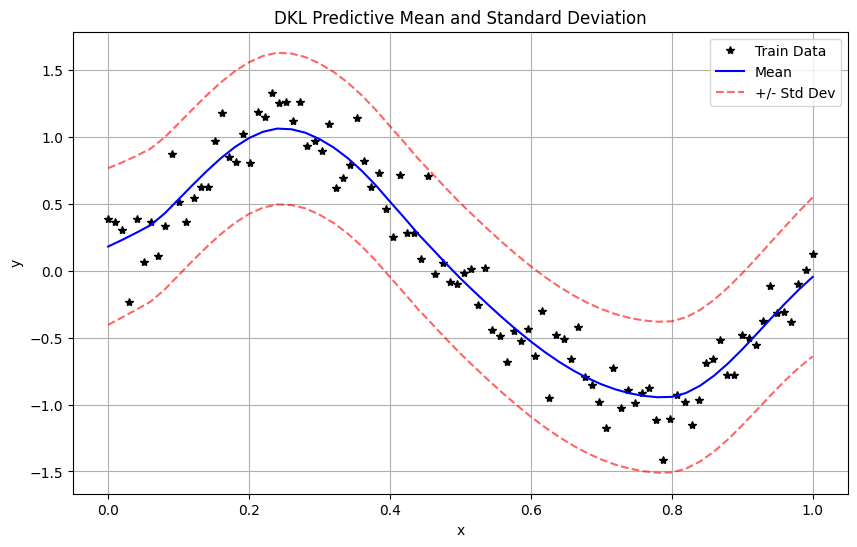

In [4]:
import torch
import gpytorch
from matplotlib import pyplot as plt

# Set a seed for reproducibility
torch.manual_seed(42)

# Toy data
train_x = torch.linspace(0, 1, 100).unsqueeze(-1)
train_y = torch.sin(train_x * (2 * torch.pi)) + 0.2 * torch.randn_like(train_x)
train_y = train_y.squeeze()

# Neural net feature extractor
class FeatureExtractor(torch.nn.Sequential):
    def __init__(self):
        super().__init__(
            torch.nn.Linear(1, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
        )

# DKL model
class DKLModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        feature_extractor = FeatureExtractor()
        super().__init__(train_x, train_y, likelihood)
        self.feature_extractor = feature_extractor
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        projected_x = self.feature_extractor(x)
        mean_x = self.mean_module(projected_x)
        covar_x = self.covar_module(projected_x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = DKLModel(train_x, train_y, likelihood)

# Train mode
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Training loop
for i in range(100):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y.squeeze())
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print(f'Iter {i}, Loss: {loss.item()}')

# Eval mode
model.eval()
likelihood.eval()
with torch.no_grad():
    test_x = torch.linspace(0, 1, 51).unsqueeze(-1)
    preds = likelihood(model(test_x))
    mean = preds.mean
    lower, upper = preds.confidence_region()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_x.numpy(), train_y.numpy(), 'k*') #plt trainin data as black stars
plt.plot(test_x.numpy(), mean.numpy(), 'b') #plt predictive mean as blue line
plt.fill_between(test_x.squeeze().numpy(), lower.numpy(), upper.numpy(), alpha=0.3) # shade between confidence bounds
plt.title("DKL GP Regression")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Train Data", "Mean Prediction", "Confidence Interval"])
plt.grid(True)
plt.show()

std_dev = preds.variance.sqrt()

plt.figure(figsize=(10, 6))
plt.plot(train_x.numpy(), train_y.numpy(), 'k*')
plt.plot(test_x.numpy(), mean.numpy(), 'b')
plt.plot(test_x.numpy(), (mean + std_dev).numpy(), 'r--', alpha=0.6)
plt.plot(test_x.numpy(), (mean - std_dev).numpy(), 'r--', alpha=0.6)
plt.title("DKL Predictive Mean and Standard Deviation")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.legend(["Train Data", "Mean", "+/- Std Dev"])
plt.show()


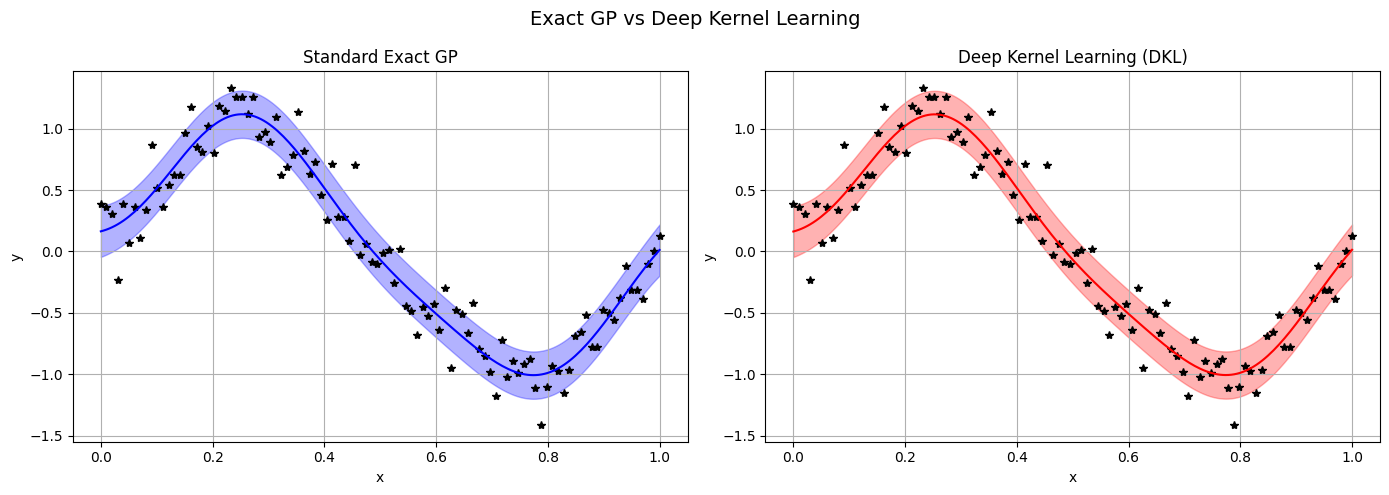

In [16]:
## below is an example showing how it compares to Exact Gaussian

import torch
import gpytorch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Set random seed for reproducibility
torch.manual_seed(42)

# Generate toy data
train_x = torch.linspace(0, 1, 100).unsqueeze(-1)
train_y = torch.sin(train_x * (2 * torch.pi)) + 0.2 * torch.randn_like(train_x)
train_y = train_y.squeeze()

# =========================
# Standard Exact GP Model
# =========================
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

gp_likelihood = gpytorch.likelihoods.GaussianLikelihood()
gp_model = ExactGPModel(train_x, train_y, gp_likelihood)

# =========================
# DKL Model (with learned kernel via NN)
# =========================
class FeatureExtractor(torch.nn.Sequential):
    def __init__(self):
        super().__init__(
            torch.nn.Linear(1, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1)
        )

class DKLModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, feature_extractor):
        super().__init__(train_x, train_y, likelihood)
        self.feature_extractor = feature_extractor
        self.mean_module = gpytorch.means.ConstantMean()
        # Use a learned kernel based on the neural network output
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        projected_x = self.feature_extractor(x)  # NN output
        mean_x = self.mean_module(projected_x)
        covar_x = self.covar_module(projected_x)  # you can change this to just x (instead of porjected_x) to make the model more interpretable. This essentially means covariance is learned on raw data rather than NN transformed data
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

dkl_feature_extractor = FeatureExtractor()
dkl_likelihood = gpytorch.likelihoods.GaussianLikelihood()
dkl_model = DKLModel(train_x, train_y, dkl_likelihood, dkl_feature_extractor)

# =========================
# Train both models
# =========================
def train(model, likelihood, n_iter=100):
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(n_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y.squeeze())
        loss.backward()
        optimizer.step()

train(gp_model, gp_likelihood)
train(dkl_model, dkl_likelihood)

# =========================
# Predict with both models
# =========================
test_x = torch.linspace(0, 1, 200).unsqueeze(-1)

def predict(model, likelihood):
    model.eval()
    likelihood.eval()
    with torch.no_grad():
        preds = likelihood(model(test_x))
    return preds.mean, preds.variance.sqrt()

gp_mean, gp_std = predict(gp_model, gp_likelihood)
dkl_mean, dkl_std = predict(dkl_model, dkl_likelihood)

# =========================
# Plot results
# =========================
fig = plt.figure(figsize=(14, 5))
gs = GridSpec(1, 2)

# GP Plot
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(train_x.numpy(), train_y.numpy(), 'k*')
ax1.plot(test_x.numpy(), gp_mean.numpy(), 'b')
ax1.fill_between(test_x.squeeze().numpy(),
                 (gp_mean - gp_std).numpy(),
                 (gp_mean + gp_std).numpy(),
                 alpha=0.3, color='blue')
ax1.set_title("Standard Exact GP")

# DKL Plot
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(train_x.numpy(), train_y.numpy(), 'k*')
ax2.plot(test_x.numpy(), dkl_mean.numpy(), 'r')
ax2.fill_between(test_x.squeeze().numpy(),
                 (dkl_mean - dkl_std).numpy(),
                 (dkl_mean + dkl_std).numpy(),
                 alpha=0.3, color='red')
ax2.set_title("Deep Kernel Learning (DKL)")

for ax in [ax1, ax2]:
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.grid(True)

plt.suptitle("Exact GP vs Deep Kernel Learning", fontsize=14)
plt.tight_layout()
plt.show()


[1/400] Loss: 51.874
[10/400] Loss: 49.490
[20/400] Loss: 42.593
[30/400] Loss: 43.165
[40/400] Loss: 34.202
[50/400] Loss: 32.519
[60/400] Loss: 33.848
[70/400] Loss: 30.486
[80/400] Loss: 29.151
[90/400] Loss: 27.667
[100/400] Loss: 26.165
[110/400] Loss: 26.731
[120/400] Loss: 25.435
[130/400] Loss: 23.257
[140/400] Loss: 22.514
[150/400] Loss: 21.819
[160/400] Loss: 21.367
[170/400] Loss: 21.410
[180/400] Loss: 21.267
[190/400] Loss: 19.675
[200/400] Loss: 21.777
[210/400] Loss: 20.913
[220/400] Loss: 20.322
[230/400] Loss: 19.783
[240/400] Loss: 19.324
[250/400] Loss: 18.820
[260/400] Loss: 18.455
[270/400] Loss: 18.054
[280/400] Loss: 17.774
[290/400] Loss: 17.348
[300/400] Loss: 17.044
[310/400] Loss: 16.759
[320/400] Loss: 16.589
[330/400] Loss: 16.158
[340/400] Loss: 15.918
[350/400] Loss: 15.612
[360/400] Loss: 15.425
[370/400] Loss: 15.174
[380/400] Loss: 16.366
[390/400] Loss: 15.832
[400/400] Loss: 14.863


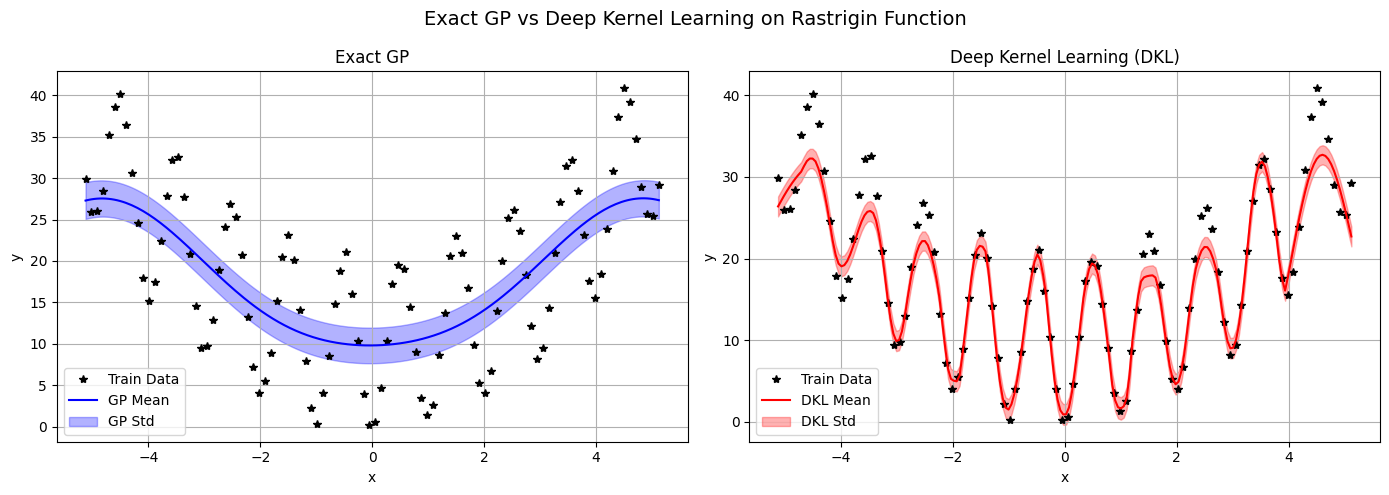

In [56]:
# Below is a cool example of how DKL can be used to improve model fit 
# note that the training method for each is different and I focused on fitting the DKL

import torch
import gpytorch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

torch.manual_seed(42)

# ---------------------
# Rastrigin Function
# ---------------------
def rastrigin(x, A=10):
    return A * x.size(-1) + torch.sum(x**2 - A * torch.cos(2 * torch.pi * x), dim=-1)

# Training data
train_x = torch.linspace(-5.12, 5.12, 100).unsqueeze(-1)  # [100, 1]
train_y = rastrigin(train_x) + 0.5 * torch.randn(train_x.size(0))  # [100]

# ---------------------
# Exact GP
# ---------------------
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

gp_likelihood = gpytorch.likelihoods.GaussianLikelihood()
gp_model = ExactGPModel(train_x, train_y, gp_likelihood)

# ---------------------
# DKL GP
# ---------------------
class FeatureExtractor(torch.nn.Sequential): # I tested a few different architecture depth and netork sizes and the below seems to work well.
    def __init__(self):
        super().__init__(
            torch.nn.Linear(1, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 32),
        )

class DKLModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, feature_extractor):
        super().__init__(train_x, train_y, likelihood)
        self.feature_extractor = feature_extractor
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        projected_x = self.feature_extractor(x).squeeze(-1)  # Critical fix
        mean_x = self.mean_module(projected_x)
        covar_x = self.covar_module(projected_x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

dkl_feature_extractor = FeatureExtractor()
dkl_likelihood = gpytorch.likelihoods.GaussianLikelihood()
dkl_model = DKLModel(train_x, train_y, dkl_likelihood, dkl_feature_extractor)

# ---------------------
# Training function
# ---------------------
def train(model, likelihood, n_iter=100):
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(n_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

def train_dkl(model, likelihood, n_iter=400):
    model.train()
    likelihood.train()

    # Split optimizer: lower LR for GP kernel/likelihood
    feature_params = list(model.feature_extractor.parameters())
    gp_params = list(model.mean_module.parameters()) + list(model.covar_module.parameters()) + list(likelihood.parameters())

    optimizer = torch.optim.Adam([
        {'params': feature_params, 'lr': 1e-2},
        {'params': gp_params, 'lr': 5e-3}
    ])

    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(n_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        if (i + 1) % 10 == 0 or i == 0:
            print(f"[{i+1}/{n_iter}] Loss: {loss.item():.3f}")
        optimizer.step()
train(gp_model, gp_likelihood)
train_dkl(dkl_model, dkl_likelihood)

# ---------------------
# Prediction
# ---------------------
test_x = torch.linspace(-5.12, 5.12, 200).unsqueeze(-1)

def predict(model, likelihood):
    model.eval()
    likelihood.eval()
    with torch.no_grad():
        preds = likelihood(model(test_x))
    return preds.mean, preds.stddev

gp_mean, gp_std = predict(gp_model, gp_likelihood)
dkl_mean, dkl_std = predict(dkl_model, dkl_likelihood)

# ---------------------
# Plotting
# ---------------------
fig = plt.figure(figsize=(14, 5))
gs = GridSpec(1, 2)

# Exact GP
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(train_x.numpy(), train_y.numpy(), 'k*', label="Train Data")
ax1.plot(test_x.numpy(), gp_mean.numpy(), 'b', label="GP Mean")
ax1.fill_between(test_x.squeeze().numpy(),
                 (gp_mean - gp_std).numpy(),
                 (gp_mean + gp_std).numpy(),
                 alpha=0.3, color='blue', label="GP Std")
ax1.set_title("Exact GP")
ax1.legend()

# DKL
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(train_x.numpy(), train_y.numpy(), 'k*', label="Train Data")
ax2.plot(test_x.numpy(), dkl_mean.numpy(), 'r', label="DKL Mean")
ax2.fill_between(test_x.squeeze().numpy(),
                 (dkl_mean - dkl_std).numpy(),
                 (dkl_mean + dkl_std).numpy(),
                 alpha=0.3, color='red', label="DKL Std")
ax2.set_title("Deep Kernel Learning (DKL)")
ax2.legend()

for ax in [ax1, ax2]:
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.grid(True)

plt.suptitle("Exact GP vs Deep Kernel Learning on Rastrigin Function", fontsize=14)
plt.tight_layout()
plt.show()


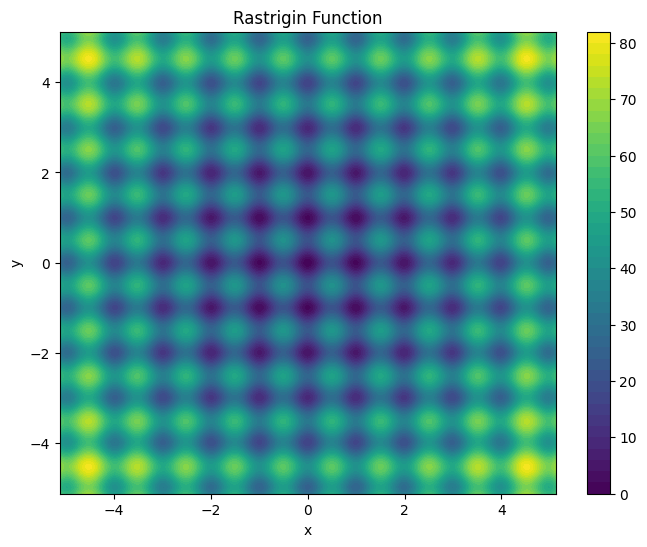

In [ ]:
# just a visualization of the Rastrigin function (this doesn't fit into above code without changing numpy functions)
import numpy as np
import matplotlib.pyplot as plt

# Define the Rastrigin function
def rastrigin(x, y):
    return 20 + x**2 + y**2 - 10 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))

# Create a grid of points
x = np.linspace(-5.12, 5.12, 400)
y = np.linspace(-5.12, 5.12, 400)
X, Y = np.meshgrid(x, y)
Z = rastrigin(X, Y)

# Plot the function
plt.figure(figsize=(8, 6))
cp = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(cp)
plt.title('Rastrigin Function')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


[1/400] Loss: 51.874
[10/400] Loss: 49.490
[20/400] Loss: 42.593
[30/400] Loss: 43.165
[40/400] Loss: 34.202
[50/400] Loss: 32.519
[60/400] Loss: 33.848
[70/400] Loss: 30.486
[80/400] Loss: 29.151
[90/400] Loss: 27.667
[100/400] Loss: 26.165
[110/400] Loss: 26.731
[120/400] Loss: 25.435
[130/400] Loss: 23.257
[140/400] Loss: 22.514
[150/400] Loss: 21.819
[160/400] Loss: 21.367
[170/400] Loss: 21.410
[180/400] Loss: 21.267
[190/400] Loss: 19.675
[200/400] Loss: 21.777
[210/400] Loss: 20.913
[220/400] Loss: 20.322
[230/400] Loss: 19.783
[240/400] Loss: 19.324
[250/400] Loss: 18.820
[260/400] Loss: 18.455
[270/400] Loss: 18.054
[280/400] Loss: 17.774
[290/400] Loss: 17.348
[300/400] Loss: 17.044
[310/400] Loss: 16.759
[320/400] Loss: 16.589
[330/400] Loss: 16.158
[340/400] Loss: 15.918
[350/400] Loss: 15.612
[360/400] Loss: 15.425
[370/400] Loss: 15.174
[380/400] Loss: 16.366
[390/400] Loss: 15.832
[400/400] Loss: 14.863


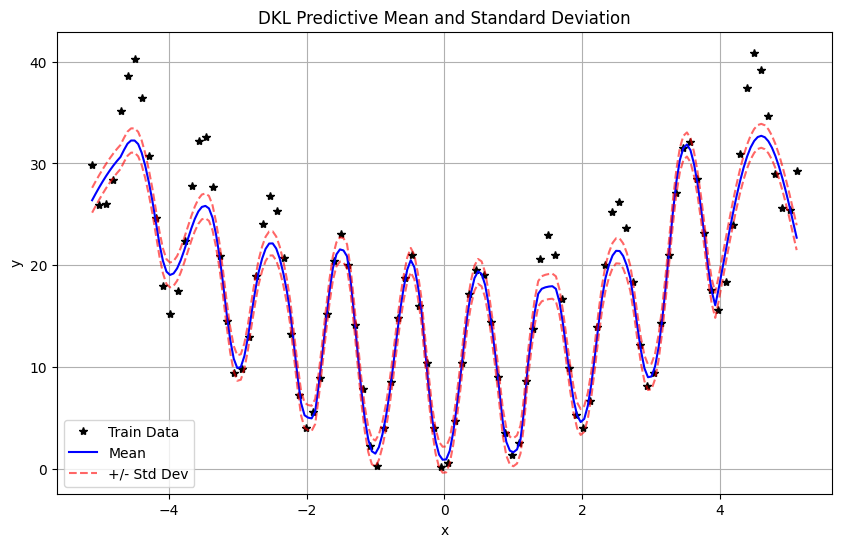

In [ ]:
#This is the exact same DKL code as above run on the Rastigrin function (without ExactGP) 
# to shorten the script for DKL template
# I also just use the plot with std dev

import torch
import gpytorch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

torch.manual_seed(42)

# ---------------------
# Rastrigin Function
# ---------------------
def rastrigin(x, A=10):
    return A * x.size(-1) + torch.sum(x**2 - A * torch.cos(2 * torch.pi * x), dim=-1)

# Training data
train_x = torch.linspace(-5.12, 5.12, 100).unsqueeze(-1)  # [100, 1]
train_y = rastrigin(train_x) + 0.5 * torch.randn(train_x.size(0))  # [100]

# DKL architecture
class FeatureExtractor(torch.nn.Sequential): # I tested a few different architecture depth and netork sizes and the below seems to work well.
    def __init__(self):
        super().__init__(
            torch.nn.Linear(1, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 32),
        )

class DKLModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, feature_extractor):
        super().__init__(train_x, train_y, likelihood)
        self.feature_extractor = feature_extractor
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        projected_x = self.feature_extractor(x).squeeze(-1)  # Critical fix
        mean_x = self.mean_module(projected_x)
        covar_x = self.covar_module(projected_x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

dkl_feature_extractor = FeatureExtractor()
dkl_likelihood = gpytorch.likelihoods.GaussianLikelihood()
dkl_model = DKLModel(train_x, train_y, dkl_likelihood, dkl_feature_extractor)

# training
def train_dkl(model, likelihood, n_iter=400):
    model.train()
    likelihood.train()

    # Split optimizer: lower LR for GP kernel/likelihood
    feature_params = list(model.feature_extractor.parameters())
    gp_params = list(model.mean_module.parameters()) + list(model.covar_module.parameters()) + list(likelihood.parameters())

    optimizer = torch.optim.Adam([
        {'params': feature_params, 'lr': 1e-2},
        {'params': gp_params, 'lr': 5e-3}
    ])

    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(n_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        if (i + 1) % 10 == 0 or i == 0:
            print(f"[{i+1}/{n_iter}] Loss: {loss.item():.3f}")
        optimizer.step()

train_dkl(dkl_model, dkl_likelihood)

# predictions
test_x = torch.linspace(-5.12, 5.12, 200).unsqueeze(-1)

def predict(model, likelihood):
    model.eval()
    likelihood.eval()
    with torch.no_grad():
        preds = likelihood(model(test_x))
    return preds.mean, preds.stddev

dkl_mean, dkl_std = predict(dkl_model, dkl_likelihood)

# plotting
plt.figure(figsize=(10, 6))
plt.plot(train_x.numpy(), train_y.numpy(), 'k*')
plt.plot(test_x.numpy(), dkl_mean.numpy(), 'b')
plt.plot(test_x.numpy(), (dkl_mean + dkl_std).numpy(), 'r--', alpha=0.6)
plt.plot(test_x.numpy(), (dkl_mean - dkl_std).numpy(), 'r--', alpha=0.6)
plt.title("DKL Predictive Mean and Standard Deviation")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.legend(["Train Data", "Mean", "+/- Std Dev"])
plt.show()